In [1]:
using Random
using Distributions
using LinearAlgebra
using ForwardDiff
include("../Inversion/Plot.jl")
include("../Inversion/RWMCMC.jl")
include("../Inversion/SMC.jl")
include("../Inversion/KalmanInversion.jl")
include("../Inversion/NGD.jl")

NGD_Run (generic function with 1 method)

In [2]:
mutable struct Setup_Param{IT<:Int}
    θ_names::Array{String,1}
    N_θ::IT
    N_y::IT
end

function Setup_Param(N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], N_θ, N_y)
end

Setup_Param

In [3]:
function Gaussian_density_helper(θ_mean::Array{FT,1}, θθ_cov::Array{FT,2}, θ::Array{FT,1}) where {FT<:AbstractFloat}
    N_θ = size(θ_mean,1)
    
    return exp( -1/2*((θ - θ_mean)'* (θθ_cov\(θ - θ_mean)) )) / ( sqrt(det(θθ_cov)) )

end


function Gaussian_density(θ_mean::Array{FT,1}, θθ_cov::Array{FT,2}, θ::Array{FT,1}) where {FT<:AbstractFloat}
    N_θ = size(θ_mean,1)
    
    return exp( -1/2*((θ - θ_mean)'* (θθ_cov\(θ - θ_mean)) )) / ( (2π)^(N_θ/2)*sqrt(det(θθ_cov)) )

end

function Gaussian_2d(θ_mean::Array{FT,1}, θθ_cov::Array{FT,2}; std=2,  N_p = 100) where {FT<:AbstractFloat}
    
    N_p = 100
    std = 2
    U, S, _ = svd(θθ_cov)
    xy_p  = [cos.(LinRange(0, 2*pi, N_p))  sin.(LinRange(0, 2*pi, N_p))]'

    xy_p = U * (std * sqrt.(S) .* xy_p) + θ_mean*ones(N_p)'

    return xy_p[1, :], xy_p[2, :]
end


function KL_estimator(m, C, func_log_rho_post; N_ens = 100)
    Random.seed!(42)
    
    N_θ = length(m)
    c_weights    =  rand(Normal(0, 1), N_θ, N_ens)
    # shift mean to and covariance to I
    c_weights -= dropdims(mean(c_weights, dims=2), dims=2)*ones(N_ens)'
    U1, S1, _ = svd(c_weights)
    c_weights = (S1/sqrt(N_ens - 1.0) .\U1') *  c_weights 

    chol_C = cholesky(Hermitian(C)).L
    xs = zeros(N_ens, N_θ)
    xs .= (m * ones(N_ens)' + chol_C * c_weights)'
    
    log_rho_posts = zeros(N_ens)
    for i = 1:N_ens
        log_rho_posts[i] = func_log_rho_post(xs[i,:])
    end
    return -1/2*log(det(C)) - sum(log_rho_posts)/N_ens
end

KL_estimator (generic function with 1 method)

## Rosenbrock banana likelihood function

We will explore the question with the following inverse problem 

$$
\mathcal{G}(\theta) 
=
\begin{bmatrix}
\theta_{(2)} - \theta_{(1)}^2\\
\theta_{(1)}
\end{bmatrix} 
\qquad
\theta_{ref} = 
\begin{bmatrix}
1\\
1
\end{bmatrix} 
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
\sigma_{\eta_1}^2 & 0\\
0 & \sigma_{\eta_2}^2
\end{bmatrix} 
$$

which leads to the 2-dimensional Rosenbrock likelihood function
    
$$\exp\Big(-\frac{\left(y_1 - (\theta_{(2)} - \theta_{(1)}^2)\right)^2}{2\sigma_{\eta_1}^2} - \frac{\left(y_2 - \theta_{(1)}\right)^2}{2\sigma_{\eta_2}^2}\Big)$$

We focus on the "uninformative" Gaussian prior $\mathcal{N}(0, 10^2 I)$.
     

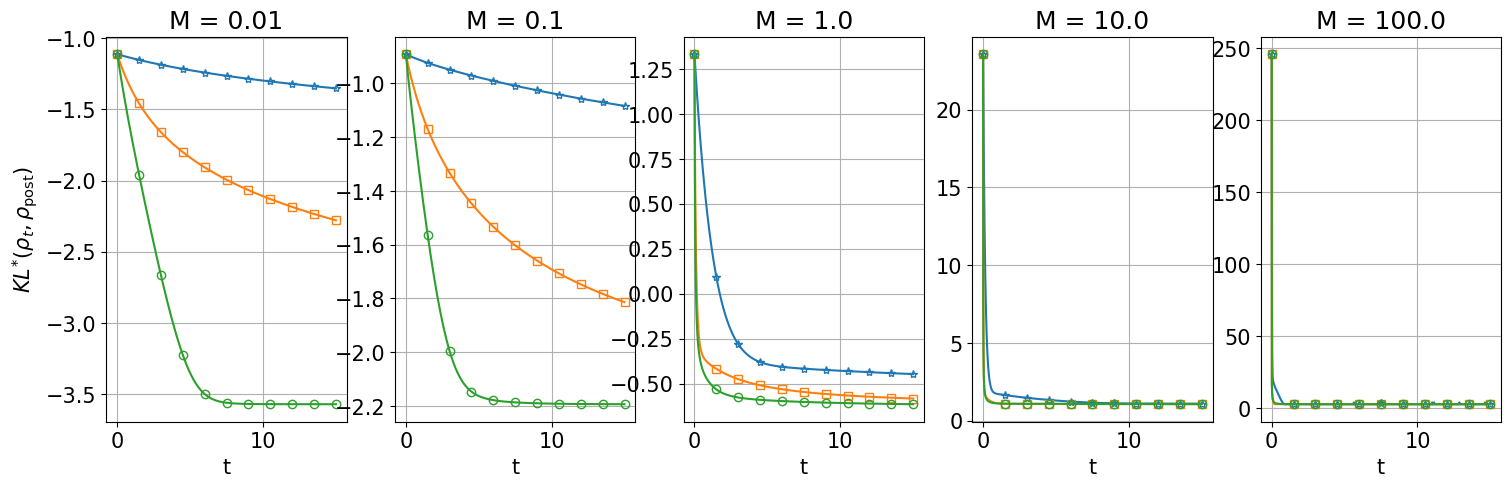

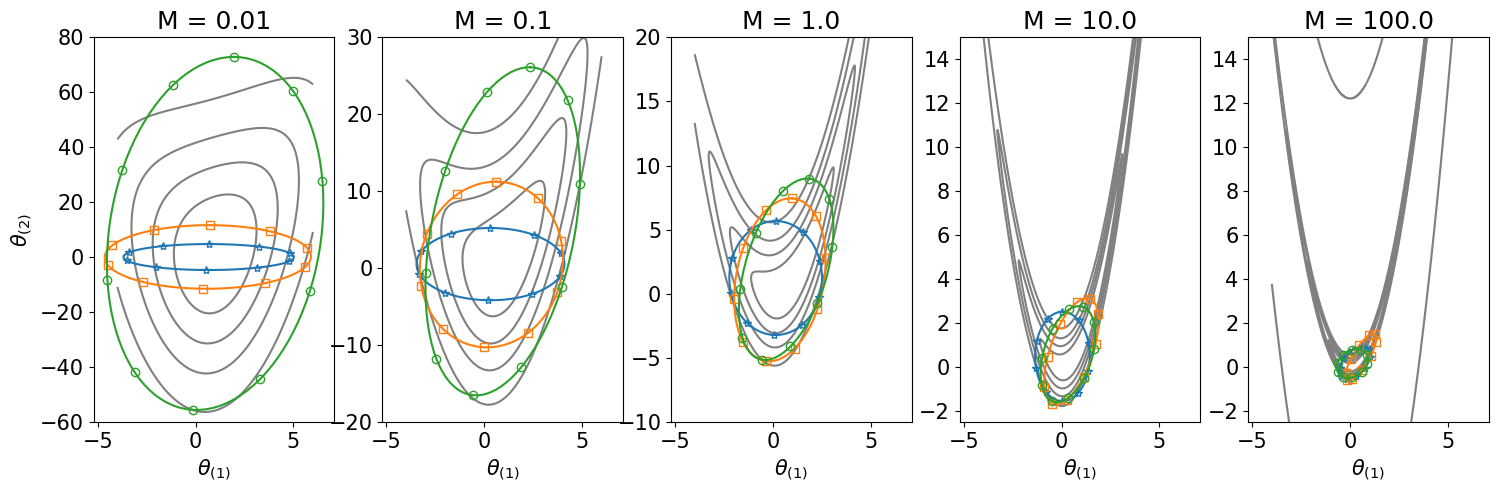

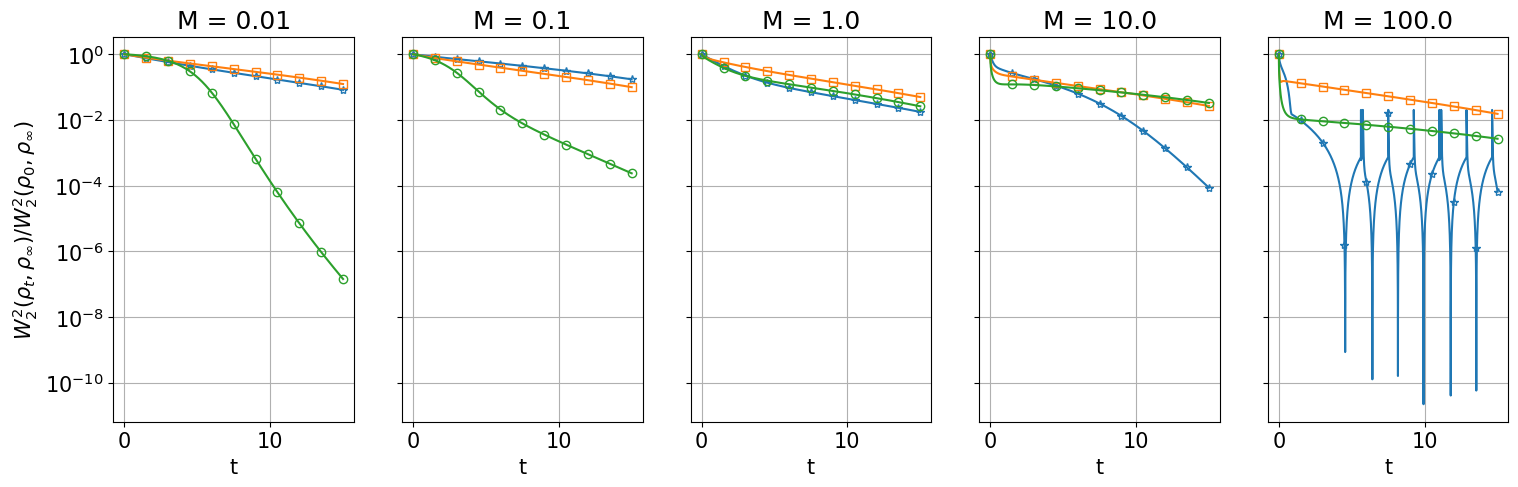

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/huang/.julia/packages/PyCall/L0fLP/src/numpy.jl:67
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[4]:60
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[4]:64
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[4]:68
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[4]:60
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[4]:64
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[4]:68
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[4]:60
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[4]:64
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[4]:68
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[4]:60
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[4]:64
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[4]:68
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[4]:60
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[4]:64
┌ Info: ("finish ", "Wasserstein"

In [4]:
# ϵs = [1, sqrt(1/10), sqrt(1/100)] 
ϵs = [0.01, 0.1, 1, 10, 100] 
fig_err, ax_err = PyPlot.subplots(ncols=length(ϵs), sharex=true, sharey=false, figsize=(18,5))
fig_scatter, ax_scatter = PyPlot.subplots(ncols=length(ϵs), sharex=true, sharey=false, figsize=(18,5))
fig_converge, ax_converge = PyPlot.subplots(ncols=length(ϵs), sharex=true, sharey=true, figsize=(18,5))

y_ranges = [[-60,80],[-20,30],[-10, 20],[-2.5, 15],[-2.5, 15]]

μ0, σ0 = [0.0;0.0], 2
Σ0 = [σ0^2 0.0;0.0  σ0^2]
y = [0.0; 1.0]
for test_id = 1:length(ϵs)
    

    Σ_η = [10/ϵs[test_id]  0.0;  0.0  10]
    

    function log_Rosenbrock( θ )
        θ₁, θ₂ = θ
        return -ϵs[test_id]*(θ₂ - θ₁^2)^2/20 - (1.0 - θ₁)^2/20  #+ log_prior(θ)
    end

    function compute_Φ(s_param, θ) 
        Φ =   -log_Rosenbrock(θ)
        dΦ =  -ForwardDiff.gradient(log_Rosenbrock, θ)
        ddΦ = -ForwardDiff.hessian(log_Rosenbrock, θ)
        return Φ, dΦ, ddΦ
    end


    # compute posterior distribution by MCMC
    x_min, x_max = -4.0, 6.0
    y_min, y_max = y_ranges[test_id]
    N_x, N_y = 1000, 1000
    xx = Array(LinRange(x_min, x_max, N_x))
    yy = Array(LinRange(y_min, y_max, N_y))
    X,Y = repeat(xx, 1, N_y), repeat(yy, 1, N_x)'
    Z = zeros(N_x, N_y)
    for i = 1:N_x
        for j = 1:N_y
            Z[i, j] = log_Rosenbrock( [X[i,j], Y[i,j]] )
        end
    end
    Z .= exp.(Z)
    ax_scatter[test_id].contour(X, Y, Z, 5, colors="grey")
            
            
    N_θ = 2
    s_param = Setup_Param(N_θ, length(y)+N_θ)
    Φ_func(s_param, θ) = compute_Φ(s_param, θ) 
    sampling_method = "UnscentedTransform"
    N_ens = 1000
    Δt = 0.001
    N_iter_tot = 30000
    
    
    compute_gradient = true
    gradient_flow = "Fisher-Rao"
    ngd_obj = NGD_Run(s_param, Φ_func, μ0, Σ0, sampling_method, N_ens,  Δt, N_iter_tot, compute_gradient, gradient_flow);
    @info "finish ", gradient_flow
    
    gradient_flow = "Gradient_descent"
    gd_obj = NGD_Run(s_param, Φ_func, μ0, Σ0, sampling_method, N_ens,  Δt, N_iter_tot, compute_gradient, gradient_flow);
    @info "finish ", gradient_flow
    
    gradient_flow = "Wasserstein"
    wgd_obj = NGD_Run(s_param, Φ_func, μ0, Σ0, sampling_method, N_ens,  Δt, N_iter_tot, compute_gradient, gradient_flow);
    @info "finish ", gradient_flow
    
    N_iter = div(N_iter_tot, 2)
    N_p=100
    X_gd,Y_gd = Gaussian_2d(gd_obj.θ_mean[N_iter], gd_obj.θθ_cov[N_iter]; std = 3, N_p=N_p)
    ax_scatter[test_id].plot(X_gd, Y_gd, "-*", fillstyle="none", markevery=div(N_p, 10), color="C0", label="Gradient descent")
    X_wgd,Y_wgd = Gaussian_2d(wgd_obj.θ_mean[N_iter], wgd_obj.θθ_cov[N_iter])
    ax_scatter[test_id].plot(X_wgd, Y_wgd, "-s", fillstyle="none", markevery=div(N_p, 10), color="C1", label="Wasserstein gradient descent")
    X_ngd,Y_ngd = Gaussian_2d(ngd_obj.θ_mean[N_iter], ngd_obj.θθ_cov[N_iter])
    ax_scatter[test_id].plot(X_ngd, Y_ngd, "-o", fillstyle="none", markevery=div(N_p, 10), color="C2", label="Natural gradient descent")
    ax_scatter[test_id].set_title("M = " * string(ϵs[test_id]))
    
    if test_id ==1
        ax_scatter[test_id].set_ylabel(L"\theta_{(2)}")
    end
    ax_scatter[test_id].set_xlabel(L"\theta_{(1)}")
#     if test_id == length(ϵs)
#         ax_scatter[test_id].legend(bbox_to_anchor=(1.0, 1.0))
#     end
    
    e_gd = zeros(N_iter+1)
    e_wgd = zeros(N_iter+1)
    e_ngd = zeros(N_iter+1)
    for i = 1:N_iter+1
        e_gd[i]  = KL_estimator(gd_obj.θ_mean[i],  gd_obj.θθ_cov[i], log_Rosenbrock)  
        e_wgd[i] = KL_estimator(wgd_obj.θ_mean[i], wgd_obj.θθ_cov[i], log_Rosenbrock)  
        e_ngd[i] = KL_estimator(ngd_obj.θ_mean[i], ngd_obj.θθ_cov[i], log_Rosenbrock)  
    end
    
    ts = Array(0:N_iter) * Δt
    markevery = div(N_iter,10)
    ax_err[test_id].plot(ts, e_gd,  "-*", fillstyle="none", markevery=div(N_iter, 10), label="Gradient descent")
    ax_err[test_id].plot(ts, e_wgd, "-s", fillstyle="none", markevery=div(N_iter, 10), label="Wasserstein gradient descent")
    ax_err[test_id].plot(ts, e_ngd, "-o", fillstyle="none", markevery=div(N_iter, 10), label="Natural gradient descent")
    ax_err[test_id].set_title("M = " * string(ϵs[test_id]))
            
    if test_id ==1
        ax_err[test_id].set_ylabel(L" KL^{*}(ρ_t , ρ_{\rm post})")
    end
    
    ax_err[test_id].set_xlabel("t")
    ax_err[test_id].grid("on")
    
#     if test_id == length(ϵs)
#         ax_err[test_id].legend(bbox_to_anchor=(1.0, 1.0))
#     end
    
    
    ekl_gd, ekl_ngd, ekl_wgd = zeros(N_iter+1),  zeros(N_iter+1),  zeros(N_iter+1)
    for i = 1:N_iter+1
        
        
        m_oo, C_oo = ngd_obj.θ_mean[end], ngd_obj.θθ_cov[end]
        U,S,V = svd(C_oo)
        C_oo_sqrt = U*Diagonal(sqrt.(S))*V'
        U,S,V = svd(C_oo_sqrt * ngd_obj.θθ_cov[i] * C_oo_sqrt)
        ekl_ngd[i]  = ( norm(ngd_obj.θ_mean[i] - m_oo)^2 + tr(ngd_obj.θθ_cov[i] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )
        
        m_oo, C_oo = gd_obj.θ_mean[end], gd_obj.θθ_cov[end]
        U,S,V = svd(C_oo)
        C_oo_sqrt = U*Diagonal(sqrt.(S))*V'
        U,S,V = svd(C_oo_sqrt * gd_obj.θθ_cov[i] * C_oo_sqrt)
        ekl_gd[i]  = ( norm(gd_obj.θ_mean[i] - m_oo)^2 + tr(gd_obj.θθ_cov[i] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )


        m_oo, C_oo = wgd_obj.θ_mean[end], wgd_obj.θθ_cov[end]
        U,S,V = svd(C_oo)
        C_oo_sqrt = U*Diagonal(sqrt.(S))*V'
        U,S,V = svd(C_oo_sqrt * wgd_obj.θθ_cov[i] * C_oo_sqrt)
        ekl_wgd[i]  = ( norm(wgd_obj.θ_mean[i] - m_oo)^2 + tr(wgd_obj.θθ_cov[i] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )
    end
    
    ekl_wgd ./= ekl_wgd[1]
    ekl_gd  ./= ekl_gd[1]
    ekl_ngd ./= ekl_ngd[1]
    
    ts = Array(0:N_iter) * Δt
    markevery = div(N_iter,10)
    ax_converge[test_id].semilogy(ts, ekl_gd,  "-*", fillstyle="none", markevery=div(N_iter, 10), label="Gradient descent")
    ax_converge[test_id].semilogy(ts, ekl_wgd, "-s", fillstyle="none", markevery=div(N_iter, 10), label="Wasserstein gradient descent")
    ax_converge[test_id].semilogy(ts, ekl_ngd, "-o", fillstyle="none", markevery=div(N_iter, 10), label="Natural gradient descent")
    ax_converge[test_id].set_title("M = " * string(ϵs[test_id]))    
    if test_id ==1
        ax_converge[test_id].set_ylabel(L" W_2^2(ρ_t , ρ_{\infty}) / W_2^2(ρ_0 , ρ_{\infty})")
    end
    ax_converge[test_id].set_xlabel("t")
    ax_converge[test_id].grid("on")
    
    
end



In [5]:
handles, labels = ax_err[1].get_legend_handles_labels()
fig_err.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.96),ncol=3)
fig_err.subplots_adjust(bottom=0.15,top=0.8,left=0.06,right=0.98,hspace=0.2)
fig_err.savefig("Rosenbrock_gd_error.pdf")


handles, labels = ax_scatter[1].get_legend_handles_labels()
fig_scatter.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.96),ncol=3)
fig_scatter.subplots_adjust(bottom=0.15,top=0.8,left=0.06,right=0.98,hspace=0.2)
fig_scatter.savefig("Rosenbrock_gd_density.pdf")

handles, labels = ax_converge[1].get_legend_handles_labels()
fig_converge.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.96),ncol=3)
fig_converge.subplots_adjust(bottom=0.15,top=0.8,left=0.06,right=0.98,hspace=0.2)
fig_converge.savefig("Rosenbrock_gd_converge.pdf")






# Convex function

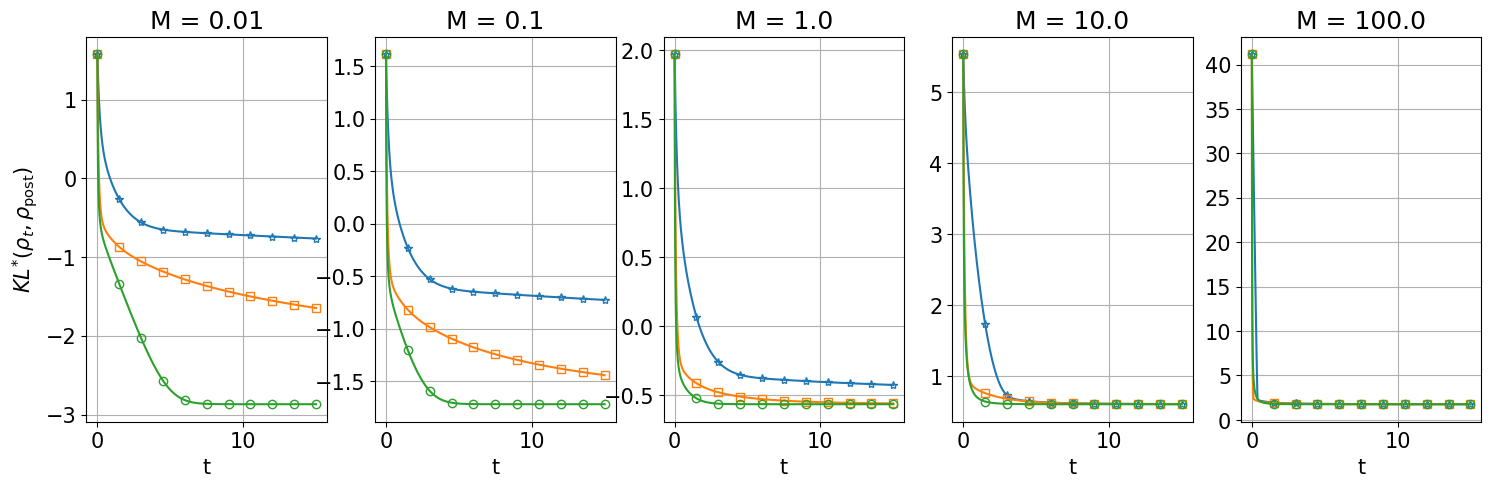

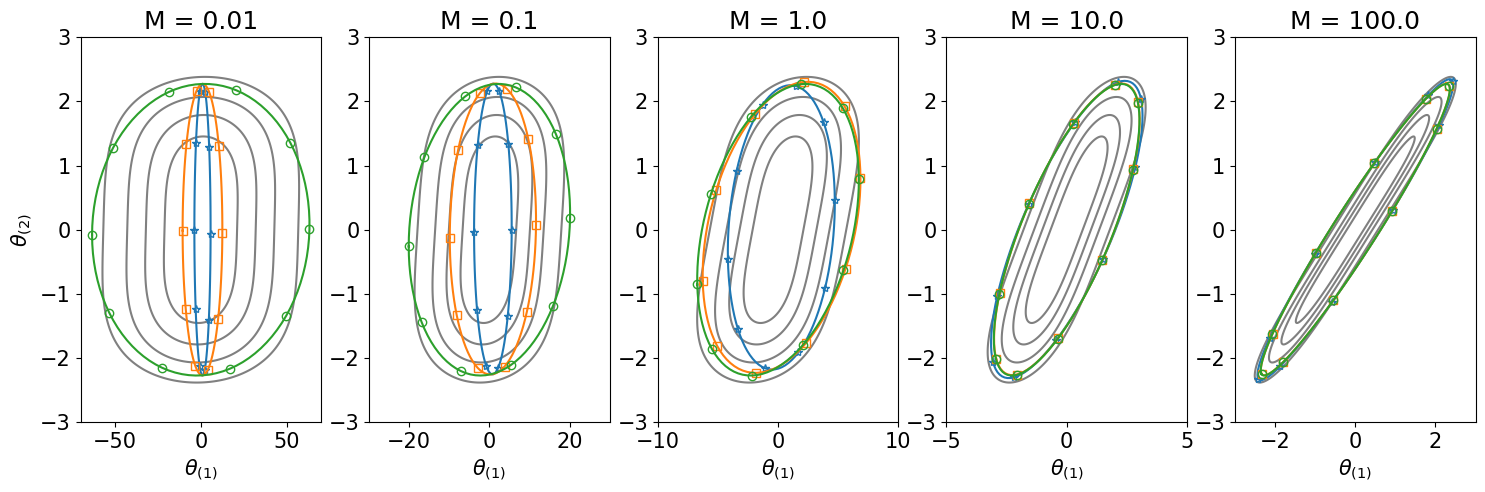

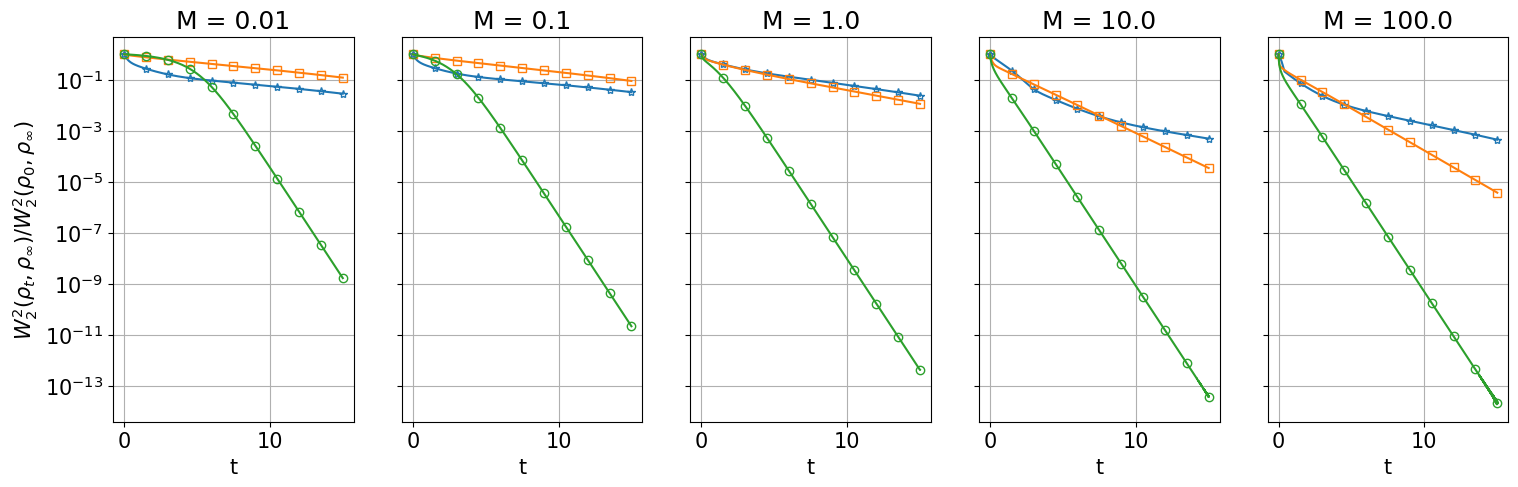

┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[6]:61
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[6]:65
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[6]:69
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[6]:61
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[6]:65
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[6]:69
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[6]:61
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[6]:65
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[6]:69
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[6]:61
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[6]:65
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[6]:69
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[6]:61
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[6]:65
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[6]:69


In [6]:
# ϵs = [1, sqrt(1/10), sqrt(1/100)] 
ϵs = [0.01, 0.1, 1, 10, 100] 
fig_err, ax_err = PyPlot.subplots(ncols=length(ϵs), sharex=true, sharey=false, figsize=(18,5))
fig_scatter, ax_scatter = PyPlot.subplots(ncols=length(ϵs), sharex=false, sharey=false, figsize=(18,5))
fig_converge, ax_converge = PyPlot.subplots(ncols=length(ϵs), sharex=true, sharey=true, figsize=(18,5))


μ0, σ0 = [1.0;1.0], 2
Σ0 = [σ0^2 0.0;0.0  σ0^2]
x_ranges = [[-70,70],[-30,30],[-10, 10],[-5, 5],[-3, 3]]
# x_ranges = [[-5,5],[-5,5],[-5,5],[-5,5],[-5,5]]
for test_id = 1:length(ϵs)
    

    Σ_η = [10/ϵs[test_id]  0.0;  0.0  10]
    

    function log_concave( θ )
        θ₁, θ₂ = θ
        #return -( ϵs[test_id]*((θ₁ - θ₂^2)^2 + θ₂^2) + (θ₁^2 + θ₂^2)^2 )/20 
        return -( ϵs[test_id]*(θ₁ - θ₂)^2 + θ₂^4)/20
    end

    function compute_Φ(s_param, θ) 
        Φ =   -log_concave(θ)
        dΦ =  -ForwardDiff.gradient(log_concave, θ)
        ddΦ = -ForwardDiff.hessian(log_concave, θ)
        return Φ, dΦ, ddΦ
    end


    # compute posterior distribution by MCMC
    x_min, x_max = x_ranges[test_id]
    y_min, y_max = -3, 3
    N_x, N_y = 1000, 1000
    xx = Array(LinRange(x_min, x_max, N_x))
    yy = Array(LinRange(y_min, y_max, N_y))
    X,Y = repeat(xx, 1, N_y), repeat(yy, 1, N_x)'
    Z = zeros(N_x, N_y)
    for i = 1:N_x
        for j = 1:N_y
            Z[i, j] = log_concave( [X[i,j], Y[i,j]] )
        end
    end
    Z .= exp.(Z)
    ax_scatter[test_id].contour(X, Y, Z, 5, colors="grey")
            
            
    N_θ = 2
    s_param = Setup_Param(N_θ, length(y)+N_θ)
    Φ_func(s_param, θ) = compute_Φ(s_param, θ) 
    sampling_method = "UnscentedTransform"
    N_ens = 1000
    Δt = 0.001
    N_iter_tot = 30000
    
    
    compute_gradient = true
    gradient_flow = "Fisher-Rao"
    ngd_obj = NGD_Run(s_param, Φ_func, μ0, Σ0, sampling_method, N_ens,  Δt, N_iter_tot, compute_gradient, gradient_flow);
    @info "finish ", gradient_flow
    
    gradient_flow = "Gradient_descent"
    gd_obj = NGD_Run(s_param, Φ_func, μ0, Σ0, sampling_method, N_ens,  Δt, N_iter_tot, compute_gradient, gradient_flow);
    @info "finish ", gradient_flow
    
    gradient_flow = "Wasserstein"
    wgd_obj = NGD_Run(s_param, Φ_func, μ0, Σ0, sampling_method, N_ens,  Δt, N_iter_tot, compute_gradient, gradient_flow);
    @info "finish ", gradient_flow
    
    N_iter = div(N_iter_tot, 2)
    N_p=100
    X_gd,Y_gd = Gaussian_2d(gd_obj.θ_mean[N_iter], gd_obj.θθ_cov[N_iter]; std = 3, N_p=N_p)
    ax_scatter[test_id].plot(X_gd, Y_gd, "-*", fillstyle="none", markevery=div(N_p, 10), color="C0", label="Gradient descent")
    X_wgd,Y_wgd = Gaussian_2d(wgd_obj.θ_mean[N_iter], wgd_obj.θθ_cov[N_iter])
    ax_scatter[test_id].plot(X_wgd, Y_wgd, "-s", fillstyle="none", markevery=div(N_p, 10), color="C1", label="Wasserstein gradient descent")
    X_ngd,Y_ngd = Gaussian_2d(ngd_obj.θ_mean[N_iter], ngd_obj.θθ_cov[N_iter])
    ax_scatter[test_id].plot(X_ngd, Y_ngd, "-o", fillstyle="none", markevery=div(N_p, 10), color="C2", label="Natural gradient descent")
    ax_scatter[test_id].set_title("M = " * string(ϵs[test_id]))
    
    if test_id ==1
        ax_scatter[test_id].set_ylabel(L"\theta_{(2)}")
    end
    ax_scatter[test_id].set_xlabel(L"\theta_{(1)}")
#     if test_id == length(ϵs)
#         ax_scatter[test_id].legend(bbox_to_anchor=(1.0, 1.0))
#     end
    
    e_gd = zeros(N_iter+1)
    e_wgd = zeros(N_iter+1)
    e_ngd = zeros(N_iter+1)
    for i = 1:N_iter+1
        e_gd[i]  = KL_estimator(gd_obj.θ_mean[i],  gd_obj.θθ_cov[i], log_concave)  
        e_wgd[i] = KL_estimator(wgd_obj.θ_mean[i], wgd_obj.θθ_cov[i], log_concave)  
        e_ngd[i] = KL_estimator(ngd_obj.θ_mean[i], ngd_obj.θθ_cov[i], log_concave)  
    end
    
    ts = Array(0:N_iter) * Δt
    markevery = div(N_iter,10)
    ax_err[test_id].plot(ts, e_gd,  "-*", fillstyle="none", markevery=div(N_iter, 10), label="Gradient descent")
    ax_err[test_id].plot(ts, e_wgd, "-s", fillstyle="none", markevery=div(N_iter, 10), label="Wasserstein gradient descent")
    ax_err[test_id].plot(ts, e_ngd, "-o", fillstyle="none", markevery=div(N_iter, 10), label="Natural gradient descent")
    ax_err[test_id].set_title("M = " * string(ϵs[test_id]))
            
    if test_id ==1
        ax_err[test_id].set_ylabel(L" KL^{*}(ρ_t , ρ_{\rm post})")
    end
    
    ax_err[test_id].set_xlabel("t")
    ax_err[test_id].grid("on")
    
#     if test_id == length(ϵs)
#         ax_err[test_id].legend(bbox_to_anchor=(1.0, 1.0))
#     end
    
    
    ekl_gd, ekl_ngd, ekl_wgd = zeros(N_iter+1),  zeros(N_iter+1),  zeros(N_iter+1)
    for i = 1:N_iter+1
        
        
        m_oo, C_oo = ngd_obj.θ_mean[end], ngd_obj.θθ_cov[end]
        U,S,V = svd(C_oo)
        C_oo_sqrt = U*Diagonal(sqrt.(S))*V'
        U,S,V = svd(C_oo_sqrt * ngd_obj.θθ_cov[i] * C_oo_sqrt)
        ekl_ngd[i]  = ( norm(ngd_obj.θ_mean[i] - m_oo)^2 + tr(ngd_obj.θθ_cov[i] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )
        
        m_oo, C_oo = gd_obj.θ_mean[end], gd_obj.θθ_cov[end]
        U,S,V = svd(C_oo)
        C_oo_sqrt = U*Diagonal(sqrt.(S))*V'
        U,S,V = svd(C_oo_sqrt * gd_obj.θθ_cov[i] * C_oo_sqrt)
        ekl_gd[i]  = ( norm(gd_obj.θ_mean[i] - m_oo)^2 + tr(gd_obj.θθ_cov[i] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )


        m_oo, C_oo = wgd_obj.θ_mean[end], wgd_obj.θθ_cov[end]
        U,S,V = svd(C_oo)
        C_oo_sqrt = U*Diagonal(sqrt.(S))*V'
        U,S,V = svd(C_oo_sqrt * wgd_obj.θθ_cov[i] * C_oo_sqrt)
        ekl_wgd[i]  = ( norm(wgd_obj.θ_mean[i] - m_oo)^2 + tr(wgd_obj.θθ_cov[i] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )
    end
    
    ekl_wgd ./= ekl_wgd[1]
    ekl_gd  ./= ekl_gd[1]
    ekl_ngd ./= ekl_ngd[1]
    
    ts = Array(0:N_iter) * Δt
    markevery = div(N_iter,10)
    ax_converge[test_id].semilogy(ts, ekl_gd,  "-*", fillstyle="none", markevery=div(N_iter, 10), label="Gradient descent")
    ax_converge[test_id].semilogy(ts, ekl_wgd, "-s", fillstyle="none", markevery=div(N_iter, 10), label="Wasserstein gradient descent")
    ax_converge[test_id].semilogy(ts, ekl_ngd, "-o", fillstyle="none", markevery=div(N_iter, 10), label="Natural gradient descent")
    ax_converge[test_id].set_title("M = " * string(ϵs[test_id]))    
    if test_id ==1
        ax_converge[test_id].set_ylabel(L" W_2^2(ρ_t , ρ_{\infty}) / W_2^2(ρ_0 , ρ_{\infty})")
    end
    ax_converge[test_id].set_xlabel("t")
    ax_converge[test_id].grid("on")
    
    
end




In [7]:
handles, labels = ax_err[1].get_legend_handles_labels()
fig_err.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.96),ncol=3)
fig_err.subplots_adjust(bottom=0.15,top=0.8,left=0.06,right=0.98,hspace=0.2)
fig_err.savefig("Logconcave_gd_error.pdf")


handles, labels = ax_scatter[1].get_legend_handles_labels()
fig_scatter.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.96),ncol=3)
fig_scatter.subplots_adjust(bottom=0.15,top=0.8,left=0.06,right=0.98,hspace=0.2)
fig_scatter.savefig("Logconcave_gd_density.pdf")

handles, labels = ax_converge[1].get_legend_handles_labels()
fig_converge.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.96),ncol=3)
fig_converge.subplots_adjust(bottom=0.15,top=0.8,left=0.06,right=0.98,hspace=0.2)
fig_converge.savefig("Logconcave_gd_converge.pdf")







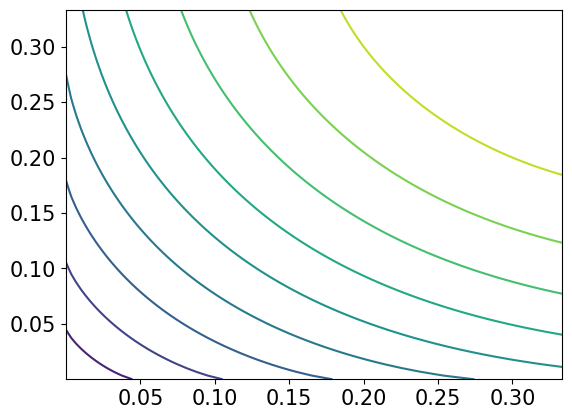

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/huang/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


PyObject <matplotlib.contour.QuadContourSet object at 0x19e7b7430>

In [5]:
function log_concave( θ )
    θ₁, θ₂ = θ
    M = 1
    return -( θ₁*log(θ₁) + θ₂*log(θ₂) +  (1 - θ₁ - θ₂)*log(1 - θ₁ - θ₂) )
end



x_min, x_max = 1e-5, 1/3
y_min, y_max = 1e-5, 1/3
N_x, N_y = 100, 100
xx = Array(LinRange(x_min, x_max, N_x))
yy = Array(LinRange(y_min, y_max, N_y))
X,Y = repeat(xx, 1, N_y), repeat(yy, 1, N_x)'
Z = zeros(N_x, N_y)
for i = 1:N_x
    for j = 1:N_y
        Z[i, j] = log_concave( [X[i,j], Y[i,j]] )
    end
end
Z .= exp.(Z)
contour(X, Y, Z, 10)

In [9]:
Z

100×100 Matrix{Float64}:
 0.0212797  0.0252256  0.0296912  …  0.043584   0.0373293  0.0317456
 0.0232259  0.0274797  0.0322834     0.047389   0.0406649  0.034649
 0.0252819  0.0298554  0.0350091     0.0513902  0.0441805  0.0377161
 0.0274478  0.0323524  0.0378676     0.0555862  0.0478756  0.0409472
 0.0297234  0.0349701  0.0408575     0.0599751  0.0517493  0.0443422
 0.0321084  0.0377072  0.0439769  …  0.0645541  0.0557998  0.0479001
 0.0346015  0.0405622  0.0472235     0.0693197  0.0600247  0.0516194
 0.0372015  0.043533   0.0505944     0.0742679  0.0644209  0.0554981
 0.0399065  0.046617   0.0540863     0.0793937  0.0689847  0.0595336
 0.0427145  0.0498116  0.0576955     0.0846916  0.073712   0.0637225
 0.0456228  0.0531132  0.0614179  …  0.0901558  0.0785979  0.0680613
 0.0486287  0.0565185  0.065249      0.0957796  0.083637   0.0725456
 0.051729   0.0600233  0.0691842     0.101556   0.0888236  0.0771707
 ⋮                                ⋱                        
 0.168791   0.18665

# Convex test 

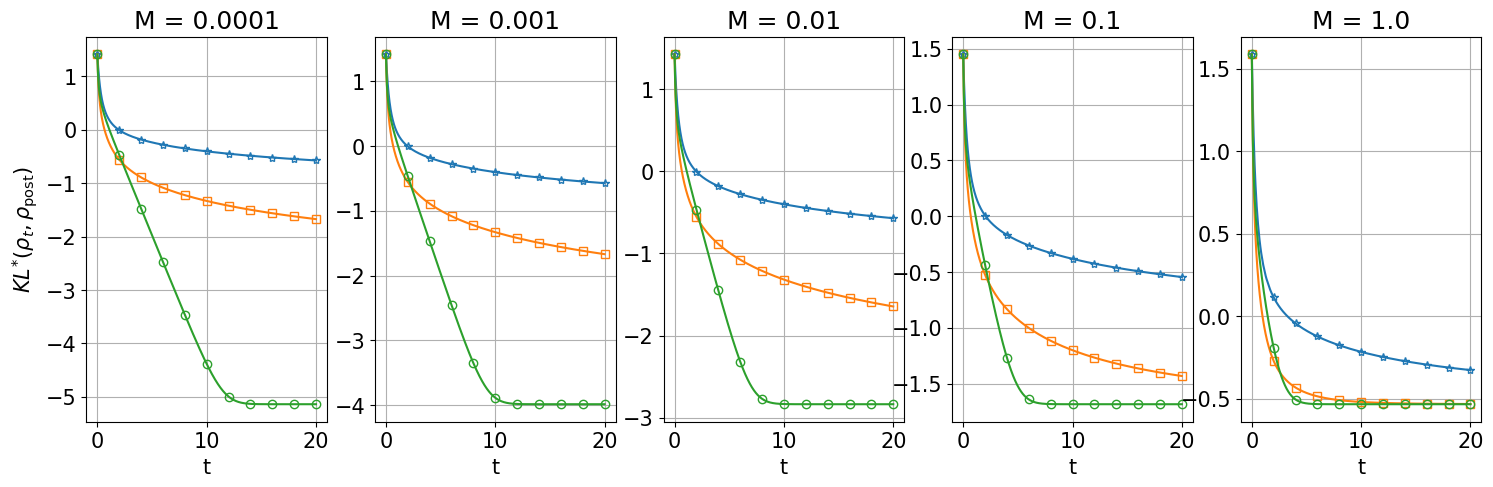

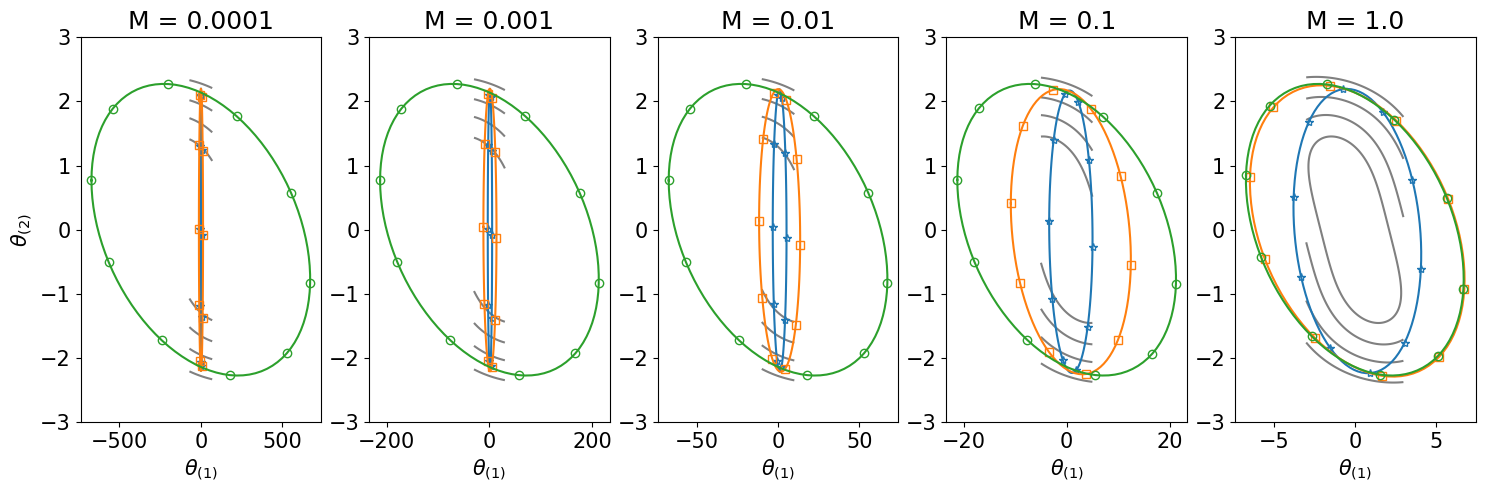

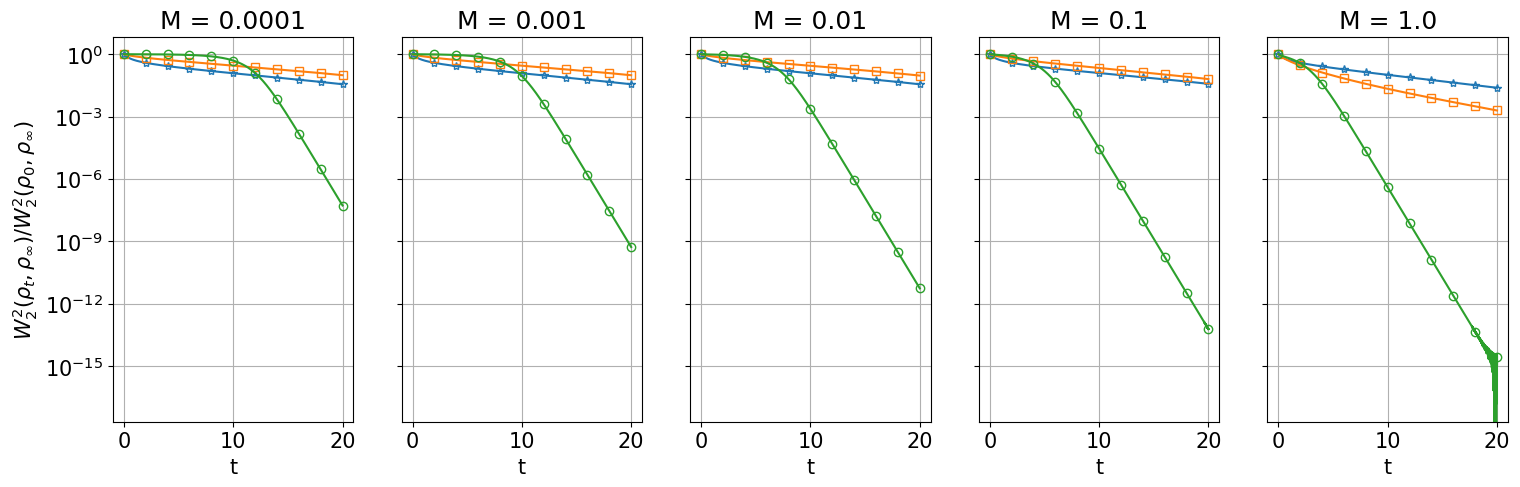

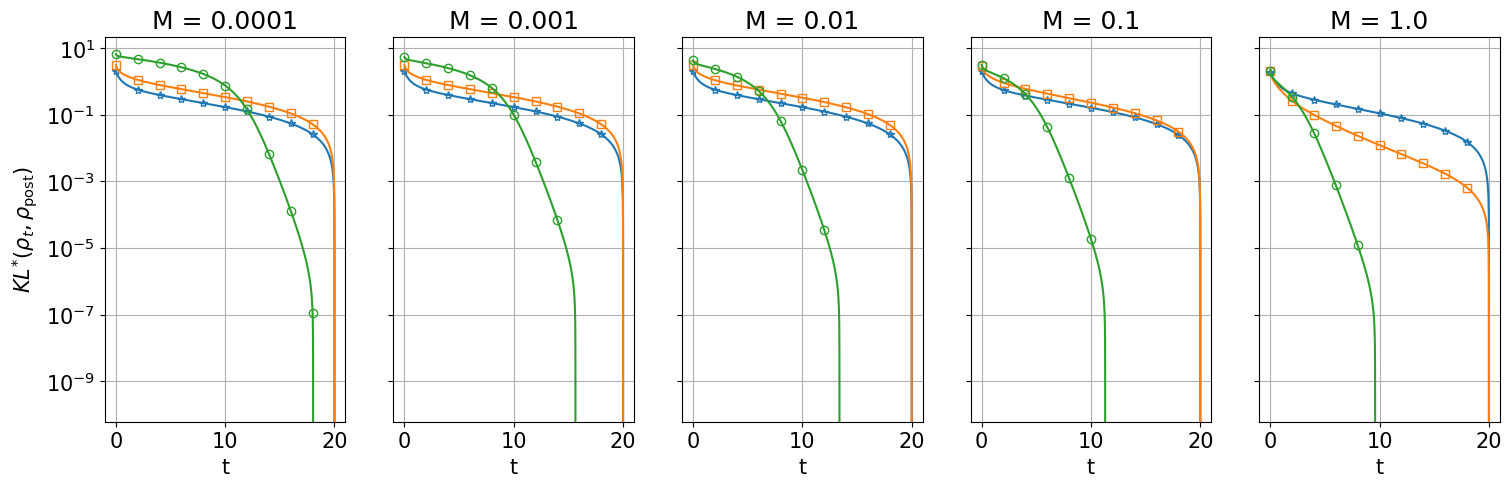

┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[26]:71
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[26]:75
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[26]:79
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[26]:71
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[26]:75
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[26]:79
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[26]:71
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[26]:75
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[26]:79
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[26]:71
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[26]:75
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[26]:79
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[26]:71
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[26]:75
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[26]:79


In [26]:
# ϵs = [1, sqrt(1/10), sqrt(1/100)] 
# ϵs = [0.01, 0.1, 1, 10, 100] 
# ϵs = [0.01, 0.1, 1, 10] 
ϵs = [0.0001, 0.001, 0.01, 0.1, 1] 
fig_err, ax_err = PyPlot.subplots(ncols=length(ϵs), sharex=true, sharey=false, figsize=(18,5))
fig_scatter, ax_scatter = PyPlot.subplots(ncols=length(ϵs), sharex=false, sharey=false, figsize=(18,5))
fig_converge, ax_converge = PyPlot.subplots(ncols=length(ϵs), sharex=true, sharey=true, figsize=(18,5))
fig_err_2, ax_err_2 = PyPlot.subplots(ncols=length(ϵs), sharex=true, sharey=true, figsize=(18,5))




# m_0 = [1; 1]
# C_0 = [1/2 0; 0 2.0]


μ0, σ0 = [1.0;1.0], 2
Σ0 = [1/2 0; 0 2.0]
x_ranges = [[-70,70],[-30,30],[-10, 10],[-5, 5],[-3, 3]]
# x_ranges = [[-5,5],[-5,5],[-5,5],[-5,5],[-5,5]]
for test_id = 1:length(ϵs)
    

    
    function log_concave( θ )
        θ₁, θ₂ = θ
        C_oo = [1 0; 0 ϵs[test_id]]
        
        #return -( ϵs[test_id]*((θ₁ - θ₂^2)^2 + θ₂^2) + (θ₁^2 + θ₂^2)^2 )/20 
        #return -(θ₁^2 + ϵs[test_id]*θ₂^2 + θ₂^4)/20
        return -((sqrt(ϵs[test_id])*θ₁ + θ₂)^2 + θ₂^4)/20
    end

    function compute_Φ(s_param, θ) 
        Φ =   -log_concave(θ)
        dΦ =  -ForwardDiff.gradient(log_concave, θ)
        ddΦ = -ForwardDiff.hessian(log_concave, θ)
        return Φ, dΦ, ddΦ
    end


    # compute posterior distribution by MCMC
    x_min, x_max = x_ranges[test_id]
    y_min, y_max = -3, 3
    N_x, N_y = 1000, 1000
    xx = Array(LinRange(x_min, x_max, N_x))
    yy = Array(LinRange(y_min, y_max, N_y))
    X,Y = repeat(xx, 1, N_y), repeat(yy, 1, N_x)'
    Z = zeros(N_x, N_y)
    for i = 1:N_x
        for j = 1:N_y
            Z[i, j] = log_concave( [X[i,j], Y[i,j]] )
        end
    end
    Z .= exp.(Z)
    ax_scatter[test_id].contour(X, Y, Z, 5, colors="grey")
            
            
    N_θ = 2
    s_param = Setup_Param(N_θ, N_θ)
    Φ_func(s_param, θ) = compute_Φ(s_param, θ) 
    sampling_method = "UnscentedTransform"
    N_ens = 1000
    Δt = 0.0005
    N_iter_tot = 80000
    
    
    compute_gradient = true
    gradient_flow = "Fisher-Rao"
    ngd_obj = NGD_Run(s_param, Φ_func, μ0, Σ0, sampling_method, N_ens,  Δt, N_iter_tot, compute_gradient, gradient_flow);
    @info "finish ", gradient_flow
    
    gradient_flow = "Gradient_descent"
    gd_obj = NGD_Run(s_param, Φ_func, μ0, Σ0, sampling_method, N_ens,  Δt, N_iter_tot, compute_gradient, gradient_flow);
    @info "finish ", gradient_flow
    
    gradient_flow = "Wasserstein"
    wgd_obj = NGD_Run(s_param, Φ_func, μ0, Σ0, sampling_method, N_ens,  Δt, N_iter_tot, compute_gradient, gradient_flow);
    @info "finish ", gradient_flow
    
    N_iter = div(N_iter_tot, 2)
    N_p=100
    X_gd,Y_gd = Gaussian_2d(gd_obj.θ_mean[N_iter], gd_obj.θθ_cov[N_iter]; std = 3, N_p=N_p)
    ax_scatter[test_id].plot(X_gd, Y_gd, "-*", fillstyle="none", markevery=div(N_p, 10), color="C0", label="Gradient descent")
    X_wgd,Y_wgd = Gaussian_2d(wgd_obj.θ_mean[N_iter], wgd_obj.θθ_cov[N_iter])
    ax_scatter[test_id].plot(X_wgd, Y_wgd, "-s", fillstyle="none", markevery=div(N_p, 10), color="C1", label="Wasserstein gradient descent")
    X_ngd,Y_ngd = Gaussian_2d(ngd_obj.θ_mean[N_iter], ngd_obj.θθ_cov[N_iter])
    ax_scatter[test_id].plot(X_ngd, Y_ngd, "-o", fillstyle="none", markevery=div(N_p, 10), color="C2", label="Natural gradient descent")
    ax_scatter[test_id].set_title("M = " * string(ϵs[test_id]))
    
    if test_id ==1
        ax_scatter[test_id].set_ylabel(L"\theta_{(2)}")
    end
    ax_scatter[test_id].set_xlabel(L"\theta_{(1)}")
#     if test_id == length(ϵs)
#         ax_scatter[test_id].legend(bbox_to_anchor=(1.0, 1.0))
#     end
    
    e_gd = zeros(N_iter+1)
    e_wgd = zeros(N_iter+1)
    e_ngd = zeros(N_iter+1)
    
    N_ens = 1000
    for i = 1:N_iter+1
        e_gd[i]  = KL_estimator(gd_obj.θ_mean[i],  gd_obj.θθ_cov[i],  log_concave; N_ens = N_ens)  
        e_wgd[i] = KL_estimator(wgd_obj.θ_mean[i], wgd_obj.θθ_cov[i], log_concave; N_ens = N_ens)  
        e_ngd[i] = KL_estimator(ngd_obj.θ_mean[i], ngd_obj.θθ_cov[i], log_concave; N_ens = N_ens)  
    end
    
    ts = Array(0:N_iter) * Δt
    markevery = div(N_iter,10)
    ax_err[test_id].plot(ts, e_gd,  "-*", fillstyle="none", markevery=div(N_iter, 10), label="Gradient descent")
    ax_err[test_id].plot(ts, e_wgd, "-s", fillstyle="none", markevery=div(N_iter, 10), label="Wasserstein gradient descent")
    ax_err[test_id].plot(ts, e_ngd, "-o", fillstyle="none", markevery=div(N_iter, 10), label="Natural gradient descent")
    ax_err[test_id].set_title("M = " * string(ϵs[test_id]))
            
    if test_id ==1
        ax_err[test_id].set_ylabel(L" KL^{*}(ρ_t , ρ_{\rm post})")
    end
    
    ax_err[test_id].set_xlabel("t")
    ax_err[test_id].grid("on")
    
    
    ####
    ax_err_2[test_id].semilogy(ts, e_gd .- e_gd[end],  "-*", fillstyle="none", markevery=div(N_iter, 10), label="Gradient descent")
    ax_err_2[test_id].semilogy(ts, e_wgd .- e_wgd[end], "-s", fillstyle="none", markevery=div(N_iter, 10), label="Wasserstein gradient descent")
    ax_err_2[test_id].semilogy(ts, e_ngd .- e_ngd[end], "-o", fillstyle="none", markevery=div(N_iter, 10), label="Natural gradient descent")
    ax_err_2[test_id].set_title("M = " * string(ϵs[test_id]))
            
    if test_id ==1
        ax_err_2[test_id].set_ylabel(L" KL^{*}(ρ_t , ρ_{\rm post})")
    end
    
    ax_err_2[test_id].set_xlabel("t")
    ax_err_2[test_id].grid("on")
    
#     if test_id == length(ϵs)
#         ax_err[test_id].legend(bbox_to_anchor=(1.0, 1.0))
#     end
    
    
    ekl_gd, ekl_ngd, ekl_wgd = zeros(N_iter+1),  zeros(N_iter+1),  zeros(N_iter+1)
    for i = 1:N_iter+1
        
        
        m_oo, C_oo = ngd_obj.θ_mean[end], ngd_obj.θθ_cov[end]
        U,S,V = svd(C_oo)
        C_oo_sqrt = U*Diagonal(sqrt.(S))*V'
        U,S,V = svd(C_oo_sqrt * ngd_obj.θθ_cov[i] * C_oo_sqrt)
        ekl_ngd[i]  = ( norm(ngd_obj.θ_mean[i] - m_oo)^2 + tr(ngd_obj.θθ_cov[i] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )
        
        m_oo, C_oo = gd_obj.θ_mean[end], gd_obj.θθ_cov[end]
        U,S,V = svd(C_oo)
        C_oo_sqrt = U*Diagonal(sqrt.(S))*V'
        U,S,V = svd(C_oo_sqrt * gd_obj.θθ_cov[i] * C_oo_sqrt)
        ekl_gd[i]  = ( norm(gd_obj.θ_mean[i] - m_oo)^2 + tr(gd_obj.θθ_cov[i] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )


        m_oo, C_oo = wgd_obj.θ_mean[end], wgd_obj.θθ_cov[end]
        U,S,V = svd(C_oo)
        C_oo_sqrt = U*Diagonal(sqrt.(S))*V'
        U,S,V = svd(C_oo_sqrt * wgd_obj.θθ_cov[i] * C_oo_sqrt)
        ekl_wgd[i]  = ( norm(wgd_obj.θ_mean[i] - m_oo)^2 + tr(wgd_obj.θθ_cov[i] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )
    end
    
    ekl_wgd ./= ekl_wgd[1]
    ekl_gd  ./= ekl_gd[1]
    ekl_ngd ./= ekl_ngd[1]
    
    ts = Array(0:N_iter) * Δt
    markevery = div(N_iter,10)
    ax_converge[test_id].semilogy(ts, ekl_gd,  "-*", fillstyle="none", markevery=div(N_iter, 10), label="Gradient descent")
    ax_converge[test_id].semilogy(ts, ekl_wgd, "-s", fillstyle="none", markevery=div(N_iter, 10), label="Wasserstein gradient descent")
    ax_converge[test_id].semilogy(ts, ekl_ngd, "-o", fillstyle="none", markevery=div(N_iter, 10), label="Natural gradient descent")
    ax_converge[test_id].set_title("M = " * string(ϵs[test_id]))    
    if test_id ==1
        ax_converge[test_id].set_ylabel(L" W_2^2(ρ_t , ρ_{\infty}) / W_2^2(ρ_0 , ρ_{\infty})")
    end
    ax_converge[test_id].set_xlabel("t")
    ax_converge[test_id].grid("on")
    
    
end





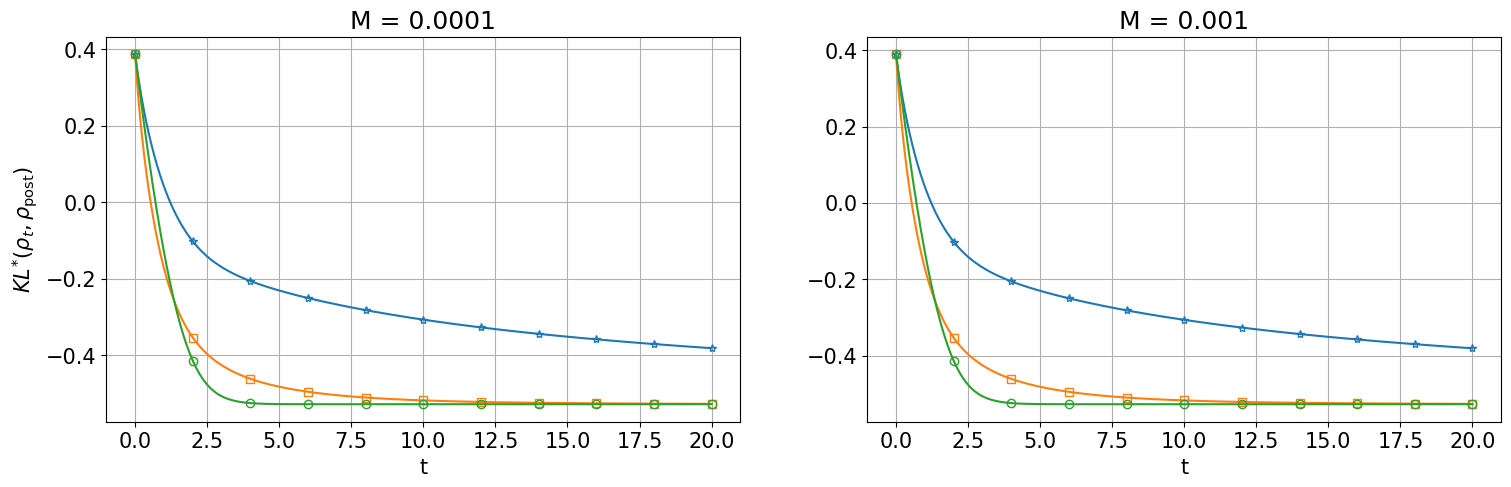

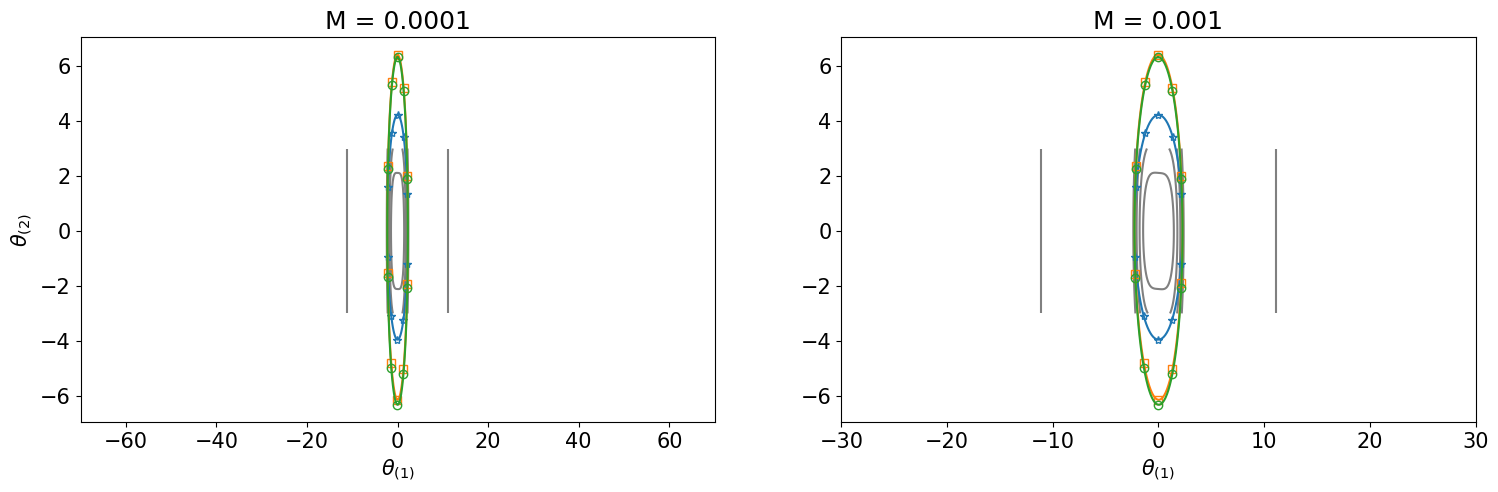

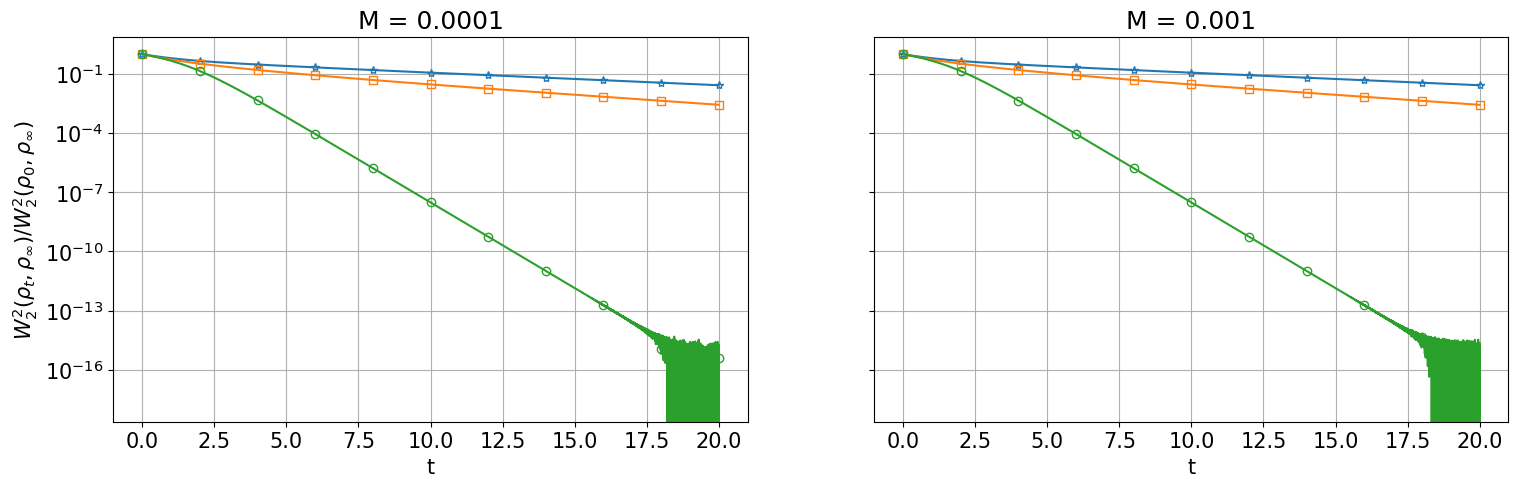

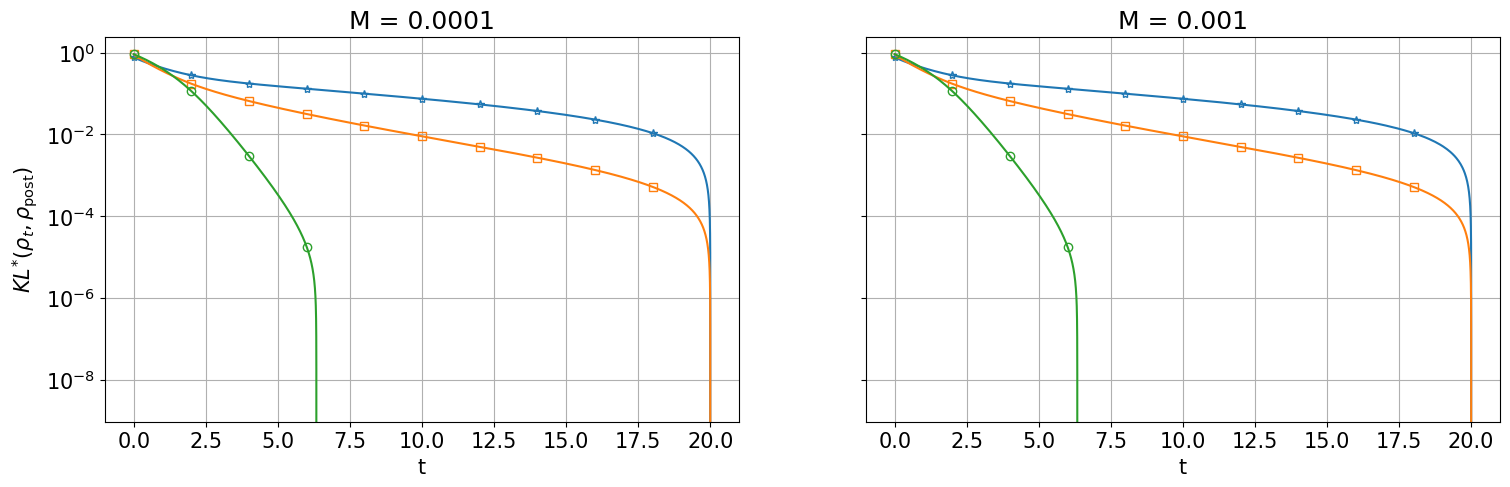

┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[27]:71
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[27]:75
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[27]:79
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[27]:71
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[27]:75
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[27]:79


In [27]:
# ϵs = [1, sqrt(1/10), sqrt(1/100)] 
# ϵs = [0.01, 0.1, 1, 10, 100] 
# ϵs = [0.01, 0.1, 1, 10] 
ϵs = [0.0001, 0.001] 
fig_err, ax_err = PyPlot.subplots(ncols=length(ϵs), sharex=true, sharey=false, figsize=(18,5))
fig_scatter, ax_scatter = PyPlot.subplots(ncols=length(ϵs), sharex=false, sharey=false, figsize=(18,5))
fig_converge, ax_converge = PyPlot.subplots(ncols=length(ϵs), sharex=true, sharey=true, figsize=(18,5))
fig_err_2, ax_err_2 = PyPlot.subplots(ncols=length(ϵs), sharex=true, sharey=true, figsize=(18,5))




# m_0 = [1; 1]
# C_0 = [1/2 0; 0 2.0]


μ0, σ0 = [1.0;1.0], 2
Σ0 = [1/2 0; 0 2.0]
x_ranges = [[-70,70],[-30,30],[-10, 10],[-5, 5],[-3, 3]]
# x_ranges = [[-5,5],[-5,5],[-5,5],[-5,5],[-5,5]]
for test_id = 1:length(ϵs)
    

    
    function log_concave( θ )
        θ₁, θ₂ = θ
        C_oo = [1 0; 0 ϵs[test_id]]
        
        #return -( ϵs[test_id]*((θ₁ - θ₂^2)^2 + θ₂^2) + (θ₁^2 + θ₂^2)^2 )/20 
        #return -(θ₁^2 + ϵs[test_id]*θ₂^2 + θ₂^4)/20
        return -((sqrt(ϵs[test_id])*θ₁ + θ₂)^2 + θ₁^4)/20
    end

    function compute_Φ(s_param, θ) 
        Φ =   -log_concave(θ)
        dΦ =  -ForwardDiff.gradient(log_concave, θ)
        ddΦ = -ForwardDiff.hessian(log_concave, θ)
        return Φ, dΦ, ddΦ
    end


    # compute posterior distribution by MCMC
    x_min, x_max = x_ranges[test_id]
    y_min, y_max = -3, 3
    N_x, N_y = 1000, 1000
    xx = Array(LinRange(x_min, x_max, N_x))
    yy = Array(LinRange(y_min, y_max, N_y))
    X,Y = repeat(xx, 1, N_y), repeat(yy, 1, N_x)'
    Z = zeros(N_x, N_y)
    for i = 1:N_x
        for j = 1:N_y
            Z[i, j] = log_concave( [X[i,j], Y[i,j]] )
        end
    end
    Z .= exp.(Z)
    ax_scatter[test_id].contour(X, Y, Z, 5, colors="grey")
            
            
    N_θ = 2
    s_param = Setup_Param(N_θ, N_θ)
    Φ_func(s_param, θ) = compute_Φ(s_param, θ) 
    sampling_method = "UnscentedTransform"
    N_ens = 1000
    Δt = 0.0005
    N_iter_tot = 80000
    
    
    compute_gradient = true
    gradient_flow = "Fisher-Rao"
    ngd_obj = NGD_Run(s_param, Φ_func, μ0, Σ0, sampling_method, N_ens,  Δt, N_iter_tot, compute_gradient, gradient_flow);
    @info "finish ", gradient_flow
    
    gradient_flow = "Gradient_descent"
    gd_obj = NGD_Run(s_param, Φ_func, μ0, Σ0, sampling_method, N_ens,  Δt, N_iter_tot, compute_gradient, gradient_flow);
    @info "finish ", gradient_flow
    
    gradient_flow = "Wasserstein"
    wgd_obj = NGD_Run(s_param, Φ_func, μ0, Σ0, sampling_method, N_ens,  Δt, N_iter_tot, compute_gradient, gradient_flow);
    @info "finish ", gradient_flow
    
    N_iter = div(N_iter_tot, 2)
    N_p=100
    X_gd,Y_gd = Gaussian_2d(gd_obj.θ_mean[N_iter], gd_obj.θθ_cov[N_iter]; std = 3, N_p=N_p)
    ax_scatter[test_id].plot(X_gd, Y_gd, "-*", fillstyle="none", markevery=div(N_p, 10), color="C0", label="Gradient descent")
    X_wgd,Y_wgd = Gaussian_2d(wgd_obj.θ_mean[N_iter], wgd_obj.θθ_cov[N_iter])
    ax_scatter[test_id].plot(X_wgd, Y_wgd, "-s", fillstyle="none", markevery=div(N_p, 10), color="C1", label="Wasserstein gradient descent")
    X_ngd,Y_ngd = Gaussian_2d(ngd_obj.θ_mean[N_iter], ngd_obj.θθ_cov[N_iter])
    ax_scatter[test_id].plot(X_ngd, Y_ngd, "-o", fillstyle="none", markevery=div(N_p, 10), color="C2", label="Natural gradient descent")
    ax_scatter[test_id].set_title("M = " * string(ϵs[test_id]))
    
    if test_id ==1
        ax_scatter[test_id].set_ylabel(L"\theta_{(2)}")
    end
    ax_scatter[test_id].set_xlabel(L"\theta_{(1)}")
#     if test_id == length(ϵs)
#         ax_scatter[test_id].legend(bbox_to_anchor=(1.0, 1.0))
#     end
    
    e_gd = zeros(N_iter+1)
    e_wgd = zeros(N_iter+1)
    e_ngd = zeros(N_iter+1)
    
    N_ens = 1000
    for i = 1:N_iter+1
        e_gd[i]  = KL_estimator(gd_obj.θ_mean[i],  gd_obj.θθ_cov[i],  log_concave; N_ens = N_ens)  
        e_wgd[i] = KL_estimator(wgd_obj.θ_mean[i], wgd_obj.θθ_cov[i], log_concave; N_ens = N_ens)  
        e_ngd[i] = KL_estimator(ngd_obj.θ_mean[i], ngd_obj.θθ_cov[i], log_concave; N_ens = N_ens)  
    end
    
    ts = Array(0:N_iter) * Δt
    markevery = div(N_iter,10)
    ax_err[test_id].plot(ts, e_gd,  "-*", fillstyle="none", markevery=div(N_iter, 10), label="Gradient descent")
    ax_err[test_id].plot(ts, e_wgd, "-s", fillstyle="none", markevery=div(N_iter, 10), label="Wasserstein gradient descent")
    ax_err[test_id].plot(ts, e_ngd, "-o", fillstyle="none", markevery=div(N_iter, 10), label="Natural gradient descent")
    ax_err[test_id].set_title("M = " * string(ϵs[test_id]))
            
    if test_id ==1
        ax_err[test_id].set_ylabel(L" KL^{*}(ρ_t , ρ_{\rm post})")
    end
    
    ax_err[test_id].set_xlabel("t")
    ax_err[test_id].grid("on")
    
    
    ####
    ax_err_2[test_id].semilogy(ts, e_gd .- e_gd[end],  "-*", fillstyle="none", markevery=div(N_iter, 10), label="Gradient descent")
    ax_err_2[test_id].semilogy(ts, e_wgd .- e_wgd[end], "-s", fillstyle="none", markevery=div(N_iter, 10), label="Wasserstein gradient descent")
    ax_err_2[test_id].semilogy(ts, e_ngd .- e_ngd[end], "-o", fillstyle="none", markevery=div(N_iter, 10), label="Natural gradient descent")
    ax_err_2[test_id].set_title("M = " * string(ϵs[test_id]))
            
    if test_id ==1
        ax_err_2[test_id].set_ylabel(L" KL^{*}(ρ_t , ρ_{\rm post})")
    end
    
    ax_err_2[test_id].set_xlabel("t")
    ax_err_2[test_id].grid("on")
    
#     if test_id == length(ϵs)
#         ax_err[test_id].legend(bbox_to_anchor=(1.0, 1.0))
#     end
    
    
    ekl_gd, ekl_ngd, ekl_wgd = zeros(N_iter+1),  zeros(N_iter+1),  zeros(N_iter+1)
    for i = 1:N_iter+1
        
        
        m_oo, C_oo = ngd_obj.θ_mean[end], ngd_obj.θθ_cov[end]
        U,S,V = svd(C_oo)
        C_oo_sqrt = U*Diagonal(sqrt.(S))*V'
        U,S,V = svd(C_oo_sqrt * ngd_obj.θθ_cov[i] * C_oo_sqrt)
        ekl_ngd[i]  = ( norm(ngd_obj.θ_mean[i] - m_oo)^2 + tr(ngd_obj.θθ_cov[i] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )
        
        m_oo, C_oo = gd_obj.θ_mean[end], gd_obj.θθ_cov[end]
        U,S,V = svd(C_oo)
        C_oo_sqrt = U*Diagonal(sqrt.(S))*V'
        U,S,V = svd(C_oo_sqrt * gd_obj.θθ_cov[i] * C_oo_sqrt)
        ekl_gd[i]  = ( norm(gd_obj.θ_mean[i] - m_oo)^2 + tr(gd_obj.θθ_cov[i] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )


        m_oo, C_oo = wgd_obj.θ_mean[end], wgd_obj.θθ_cov[end]
        U,S,V = svd(C_oo)
        C_oo_sqrt = U*Diagonal(sqrt.(S))*V'
        U,S,V = svd(C_oo_sqrt * wgd_obj.θθ_cov[i] * C_oo_sqrt)
        ekl_wgd[i]  = ( norm(wgd_obj.θ_mean[i] - m_oo)^2 + tr(wgd_obj.θθ_cov[i] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )
    end
    
    ekl_wgd ./= ekl_wgd[1]
    ekl_gd  ./= ekl_gd[1]
    ekl_ngd ./= ekl_ngd[1]
    
    ts = Array(0:N_iter) * Δt
    markevery = div(N_iter,10)
    ax_converge[test_id].semilogy(ts, ekl_gd,  "-*", fillstyle="none", markevery=div(N_iter, 10), label="Gradient descent")
    ax_converge[test_id].semilogy(ts, ekl_wgd, "-s", fillstyle="none", markevery=div(N_iter, 10), label="Wasserstein gradient descent")
    ax_converge[test_id].semilogy(ts, ekl_ngd, "-o", fillstyle="none", markevery=div(N_iter, 10), label="Natural gradient descent")
    ax_converge[test_id].set_title("M = " * string(ϵs[test_id]))    
    if test_id ==1
        ax_converge[test_id].set_ylabel(L" W_2^2(ρ_t , ρ_{\infty}) / W_2^2(ρ_0 , ρ_{\infty})")
    end
    ax_converge[test_id].set_xlabel("t")
    ax_converge[test_id].grid("on")
    
    
end






In [25]:
# ϵs = [1, sqrt(1/10), sqrt(1/100)] 
# ϵs = [0.01, 0.1, 1, 10, 100] 
# ϵs = [0.01, 0.1, 1, 10] 
ϵs = [0.0001, 0.001] 
# ϵs = [0.0001, 0.001, 0.01, 0.1, 1] 
fig_err, ax_err = PyPlot.subplots(ncols=length(ϵs), sharex=true, sharey=false, figsize=(18,5))
fig_scatter, ax_scatter = PyPlot.subplots(ncols=length(ϵs), sharex=false, sharey=false, figsize=(18,5))
fig_converge, ax_converge = PyPlot.subplots(ncols=length(ϵs), sharex=true, sharey=true, figsize=(18,5))
fig_err_2, ax_err_2 = PyPlot.subplots(ncols=length(ϵs), sharex=true, sharey=true, figsize=(18,5))




# m_0 = [1; 1]
# C_0 = [1/2 0; 0 2.0]


μ0, σ0 = [1.0;1.0], 2
Σ0 = [1/2 0; 0 2.0]
x_ranges = [[-70,70],[-30,30],[-10, 10],[-5, 5],[-3, 3]]
# x_ranges = [[-5,5],[-5,5],[-5,5],[-5,5],[-5,5]]
for test_id = 1:length(ϵs)
    

    
    function log_concave( θ )
        θ₁, θ₂ = θ
        C_oo = [1 0; 0 ϵs[test_id]]
        
        #return -( ϵs[test_id]*((θ₁ - θ₂^2)^2 + θ₂^2) + (θ₁^2 + θ₂^2)^2 )/20 
        #return -(θ₁^2 + ϵs[test_id]*θ₂^2 + θ₂^4)/20
        return -((sqrt(ϵs[test_id])*θ₁ + θ₂)^2)/20
    end

    function compute_Φ(s_param, θ) 
        Φ =   -log_concave(θ)
        dΦ =  -ForwardDiff.gradient(log_concave, θ)
        ddΦ = -ForwardDiff.hessian(log_concave, θ)
        return Φ, dΦ, ddΦ
    end


    # compute posterior distribution by MCMC
    x_min, x_max = x_ranges[test_id]
    y_min, y_max = -3, 3
    N_x, N_y = 1000, 1000
    xx = Array(LinRange(x_min, x_max, N_x))
    yy = Array(LinRange(y_min, y_max, N_y))
    X,Y = repeat(xx, 1, N_y), repeat(yy, 1, N_x)'
    Z = zeros(N_x, N_y)
    for i = 1:N_x
        for j = 1:N_y
            Z[i, j] = log_concave( [X[i,j], Y[i,j]] )
        end
    end
    Z .= exp.(Z)
    ax_scatter[test_id].contour(X, Y, Z, 5, colors="grey")
            
            
    N_θ = 2
    s_param = Setup_Param(N_θ, N_θ)
    Φ_func(s_param, θ) = compute_Φ(s_param, θ) 
    sampling_method = "UnscentedTransform"
    N_ens = 1000
    Δt = 0.001
    N_iter_tot = 120000
    
    
    compute_gradient = true
    gradient_flow = "Fisher-Rao"
    ngd_obj = NGD_Run(s_param, Φ_func, μ0, Σ0, sampling_method, N_ens,  Δt, N_iter_tot, compute_gradient, gradient_flow);
    @info "finish ", gradient_flow
    
    gradient_flow = "Gradient_descent"
    gd_obj = NGD_Run(s_param, Φ_func, μ0, Σ0, sampling_method, N_ens,  Δt, N_iter_tot, compute_gradient, gradient_flow);
    @info "finish ", gradient_flow
    
    gradient_flow = "Wasserstein"
    wgd_obj = NGD_Run(s_param, Φ_func, μ0, Σ0, sampling_method, N_ens,  Δt, N_iter_tot, compute_gradient, gradient_flow);
    @info "finish ", gradient_flow
    
    N_iter = div(N_iter_tot, 2)
    N_p=100
    X_gd,Y_gd = Gaussian_2d(gd_obj.θ_mean[N_iter], gd_obj.θθ_cov[N_iter]; std = 3, N_p=N_p)
    ax_scatter[test_id].plot(X_gd, Y_gd, "-*", fillstyle="none", markevery=div(N_p, 10), color="C0", label="Gradient descent")
    X_wgd,Y_wgd = Gaussian_2d(wgd_obj.θ_mean[N_iter], wgd_obj.θθ_cov[N_iter])
    ax_scatter[test_id].plot(X_wgd, Y_wgd, "-s", fillstyle="none", markevery=div(N_p, 10), color="C1", label="Wasserstein gradient descent")
    X_ngd,Y_ngd = Gaussian_2d(ngd_obj.θ_mean[N_iter], ngd_obj.θθ_cov[N_iter])
    ax_scatter[test_id].plot(X_ngd, Y_ngd, "-o", fillstyle="none", markevery=div(N_p, 10), color="C2", label="Natural gradient descent")
    ax_scatter[test_id].set_title("M = " * string(ϵs[test_id]))
    
    if test_id ==1
        ax_scatter[test_id].set_ylabel(L"\theta_{(2)}")
    end
    ax_scatter[test_id].set_xlabel(L"\theta_{(1)}")
#     if test_id == length(ϵs)
#         ax_scatter[test_id].legend(bbox_to_anchor=(1.0, 1.0))
#     end
    
    e_gd = zeros(N_iter+1)
    e_wgd = zeros(N_iter+1)
    e_ngd = zeros(N_iter+1)
    
    N_ens = 1000
    for i = 1:N_iter+1
        e_gd[i]  = KL_estimator(gd_obj.θ_mean[i],  gd_obj.θθ_cov[i],  log_concave; N_ens = N_ens)  
        e_wgd[i] = KL_estimator(wgd_obj.θ_mean[i], wgd_obj.θθ_cov[i], log_concave; N_ens = N_ens)  
        e_ngd[i] = KL_estimator(ngd_obj.θ_mean[i], ngd_obj.θθ_cov[i], log_concave; N_ens = N_ens)  
    end
    
    ts = Array(0:N_iter) * Δt
    markevery = div(N_iter,10)
    ax_err[test_id].plot(ts, e_gd,  "-*", fillstyle="none", markevery=div(N_iter, 10), label="Gradient descent")
    ax_err[test_id].plot(ts, e_wgd, "-s", fillstyle="none", markevery=div(N_iter, 10), label="Wasserstein gradient descent")
    ax_err[test_id].plot(ts, e_ngd, "-o", fillstyle="none", markevery=div(N_iter, 10), label="Natural gradient descent")
    ax_err[test_id].set_title("M = " * string(ϵs[test_id]))
            
    if test_id ==1
        ax_err[test_id].set_ylabel(L" KL^{*}(ρ_t , ρ_{\rm post})")
    end
    
    ax_err[test_id].set_xlabel("t")
    ax_err[test_id].grid("on")
    
    
    ####
    ax_err_2[test_id].semilogy(ts, e_gd .- e_gd[end],  "-*", fillstyle="none", markevery=div(N_iter, 10), label="Gradient descent")
    ax_err_2[test_id].semilogy(ts, e_wgd .- e_wgd[end], "-s", fillstyle="none", markevery=div(N_iter, 10), label="Wasserstein gradient descent")
    ax_err_2[test_id].semilogy(ts, e_ngd .- e_ngd[end], "-o", fillstyle="none", markevery=div(N_iter, 10), label="Natural gradient descent")
    ax_err_2[test_id].set_title("M = " * string(ϵs[test_id]))
            
    if test_id ==1
        ax_err_2[test_id].set_ylabel(L" KL^{*}(ρ_t , ρ_{\rm post})")
    end
    
    ax_err_2[test_id].set_xlabel("t")
    ax_err_2[test_id].grid("on")
    
#     if test_id == length(ϵs)
#         ax_err[test_id].legend(bbox_to_anchor=(1.0, 1.0))
#     end
    
    
    ekl_gd, ekl_ngd, ekl_wgd = zeros(N_iter+1),  zeros(N_iter+1),  zeros(N_iter+1)
    for i = 1:N_iter+1
        
        
        m_oo, C_oo = ngd_obj.θ_mean[end], ngd_obj.θθ_cov[end]
        U,S,V = svd(C_oo)
        C_oo_sqrt = U*Diagonal(sqrt.(S))*V'
        U,S,V = svd(C_oo_sqrt * ngd_obj.θθ_cov[i] * C_oo_sqrt)
        ekl_ngd[i]  = ( norm(ngd_obj.θ_mean[i] - m_oo)^2 + tr(ngd_obj.θθ_cov[i] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )
        
        m_oo, C_oo = gd_obj.θ_mean[end], gd_obj.θθ_cov[end]
        U,S,V = svd(C_oo)
        C_oo_sqrt = U*Diagonal(sqrt.(S))*V'
        U,S,V = svd(C_oo_sqrt * gd_obj.θθ_cov[i] * C_oo_sqrt)
        ekl_gd[i]  = ( norm(gd_obj.θ_mean[i] - m_oo)^2 + tr(gd_obj.θθ_cov[i] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )


        m_oo, C_oo = wgd_obj.θ_mean[end], wgd_obj.θθ_cov[end]
        U,S,V = svd(C_oo)
        C_oo_sqrt = U*Diagonal(sqrt.(S))*V'
        U,S,V = svd(C_oo_sqrt * wgd_obj.θθ_cov[i] * C_oo_sqrt)
        ekl_wgd[i]  = ( norm(wgd_obj.θ_mean[i] - m_oo)^2 + tr(wgd_obj.θθ_cov[i] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )
    end
    
    ekl_wgd ./= ekl_wgd[1]
    ekl_gd  ./= ekl_gd[1]
    ekl_ngd ./= ekl_ngd[1]
    
    ts = Array(0:N_iter) * Δt
    markevery = div(N_iter,10)
    ax_converge[test_id].semilogy(ts, ekl_gd,  "-*", fillstyle="none", markevery=div(N_iter, 10), label="Gradient descent")
    ax_converge[test_id].semilogy(ts, ekl_wgd, "-s", fillstyle="none", markevery=div(N_iter, 10), label="Wasserstein gradient descent")
    ax_converge[test_id].semilogy(ts, ekl_ngd, "-o", fillstyle="none", markevery=div(N_iter, 10), label="Natural gradient descent")
    ax_converge[test_id].set_title("M = " * string(ϵs[test_id]))    
    if test_id ==1
        ax_converge[test_id].set_ylabel(L" W_2^2(ρ_t , ρ_{\infty}) / W_2^2(ρ_0 , ρ_{\infty})")
    end
    ax_converge[test_id].set_xlabel("t")
    ax_converge[test_id].grid("on")
    
    
end






LoadError: PosDefException: matrix is not positive definite; Cholesky factorization failed.